In [157]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch_geometric.nn as tgm_nn
from torch.utils.data import Dataset, DataLoader


## Load data

In [159]:
data = pd.read_csv('./data/ieee9iters.csv', header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,0.0,0.0,1.04,0.0,0.0,0.0,1.025004,0.382556,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1
1,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.243693,0.0,0.0,...,5.588245,0.0,0.00000,-5.525946,1,1,1,1,1,0
2,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.212868,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1
3,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.527527,0.0,0.0,...,5.588245,0.0,0.00000,-5.525946,1,1,1,1,1,0
4,0.0,0.0,1.04,0.0,0.0,0.0,1.025000,0.414343,0.0,0.0,...,5.588245,0.0,9.78427,-14.936790,1,1,1,1,1,1


## Split into train and test

In [160]:
data = data.to_numpy()

TRAIN_SIZE = 0.8
train_num = int(len(data)*TRAIN_SIZE)

train_data = data[:train_num]
test_data = data[train_num:]

print("Training data has", len(train_data), "samples")
print("Test data has", len(test_data), "samples")

Training data has 4000 samples
Test data has 1000 samples


In [164]:
class IEEE9Dataset(Dataset):
    def __init__(self, raw_data):
        super().__init__()

        self.raw_data = raw_data
        self.n_buses = 9

    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, index):
        # Split into X, y and Ybus
        data = self.raw_data[index, :4*self.n_buses]
        Ybuses_real = self.raw_data[index, 4*self.n_buses:(4*self.n_buses + self.n_buses*self.n_buses)]
        Ybuses_imag = self.raw_data[index, (4*self.n_buses + self.n_buses*self.n_buses):(4*self.n_buses + self.n_buses*self.n_buses + self.n_buses*self.n_buses)]

        attention = self.raw_data[index, (4*self.n_buses + self.n_buses*self.n_buses + self.n_buses*self.n_buses):]

        X = np.zeros(2*self.n_buses)
        y = np.zeros(2)
        for n in range(self.n_buses):
            P = data[4*n]
            Q = data[4*n+1]
            V = data[4*n+2]
            theta = data[4*n+3]

            X[2*n] = P
            X[2*n+1] = Q
            y[0] = V
            y[1] = theta

        return torch.tensor(X), torch.tensor(y), torch.complex(torch.tensor(Ybuses_real), torch.tensor(Ybuses_imag)), torch.tensor(attention)
    

In [165]:
train_dataset = IEEE9Dataset(train_data)
test_dataset = IEEE9Dataset(test_data)
X, y, Ybus, attention = train_dataset[0]
print(X.shape, y.shape, Ybus.shape, attention.shape)
print(X, y)

torch.Size([18]) torch.Size([2]) torch.Size([81]) torch.Size([6])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1831,
        0.0562, 0.7506, 0.2502, 0.0000, 0.0000, 0.4179, 0.1463, 0.0000, 0.0000],
       dtype=torch.float64) tensor([1.0417, 0.2364], dtype=torch.float64)


## Create DataLoaders

In [166]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size=32,
    shuffle = True,
    drop_last = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = False
)

## Create GNN Model

In [167]:
class NN(nn.Module):
    def __init__(self, n_buses = 9):
        super(NN, self).__init__()

        self.Ybus_real_fc = nn.Linear(n_buses*n_buses, 64)
        self.Ybus_imag_fc = nn.Linear(n_buses*n_buses, 64)

        self.attention = nn.LazyLinear(64)

        self.fc1 = nn.Linear(2*n_buses, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x, Ybus, attention):
        # Split Ybus into real and imag, and flatten it
        Ybus_real = torch.real(Ybus).to(torch.float)
        Ybus_imag = torch.imag(Ybus).to(torch.float)
        
        Ybus_out1 = self.Ybus_real_fc(Ybus_real)
        Ybus_out2 = self.Ybus_imag_fc(Ybus_imag)

        attention_out = self.attention(attention)


        x = nn.functional.relu(self.fc1(x)) + Ybus_out1 + Ybus_out2 + attention_out
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x)

## Test model

In [168]:
model = NN()
X_batch, y_batch, Ybus_batch, attention = next(iter(train_loader))
X_batch = X_batch.to(torch.float)
y_batch = y_batch.to(torch.float)
attention = attention.to(torch.float)
out = model(X_batch, Ybus_batch, attention)
print(out.shape)

torch.Size([32, 2])


c:\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Train Model

In [169]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

EPOCHS = 1000
losses = []
val_losses = []
for epoch in range(1, EPOCHS+1):
    epoch_loss = 0.0
    model.train()
    for batch_idx, (X, y, Ybus, attention) in enumerate(train_loader):
        X = X.to(torch.float)
        y = y.to(torch.float)
        attention = attention.to(torch.float)

        pred = model(X, Ybus, attention)

        optimizer.zero_grad()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    model.eval()
    epoch_val_loss = 0.0
    for batch_idx, (X, y, Ybus, attention) in enumerate(test_loader):
        X = X.to(torch.float)
        y = y.to(torch.float)
        attention = attention.to(torch.float)

        pred = model(X, Ybus, attention)

        loss = criterion(pred, y)

        epoch_val_loss += loss.item()

    epoch_val_loss /= len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch: {epoch}, loss: {epoch_loss}, val_loss = {epoch_val_loss}")
    

Epoch: 1, loss: 0.031300443336367605, val_loss = 0.013058571406872943
Epoch: 2, loss: 0.010643588859587908, val_loss = 0.009388836682774127
Epoch: 3, loss: 0.007885207612067461, val_loss = 0.00736259832046926
Epoch: 4, loss: 0.00613655492849648, val_loss = 0.006139465192973148
Epoch: 5, loss: 0.005109235999174416, val_loss = 0.005214400182012469
Epoch: 6, loss: 0.004478021550923586, val_loss = 0.004786194571352098
Epoch: 7, loss: 0.0038569267829880118, val_loss = 0.0042923202527163085
Epoch: 8, loss: 0.0034410117887891827, val_loss = 0.00355489267167286
Epoch: 9, loss: 0.00302974556107074, val_loss = 0.0032474544714204967
Epoch: 10, loss: 0.0027731760232709347, val_loss = 0.002867849743779516
Epoch: 11, loss: 0.0024813275071792307, val_loss = 0.0025931997079169378
Epoch: 12, loss: 0.00222038641711697, val_loss = 0.0024539922778785694
Epoch: 13, loss: 0.002056300467578694, val_loss = 0.0023088198504410684
Epoch: 14, loss: 0.001893200058490038, val_loss = 0.0020135476188443135
Epoch: 15,

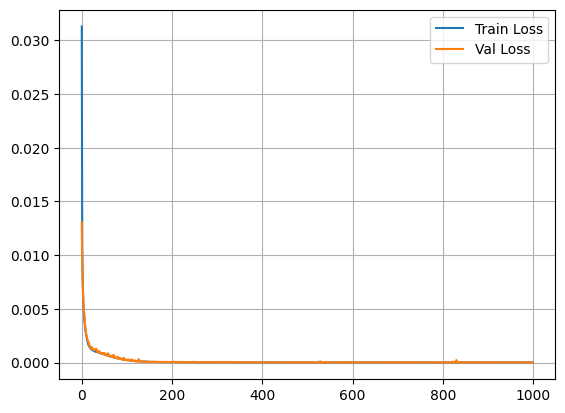

In [170]:
plt.figure()
plt.plot(losses, label = "Train Loss")
plt.plot(val_losses, label = "Val Loss")
plt.legend()
plt.grid(True)
plt.show()

## Plot latest 60 epochs

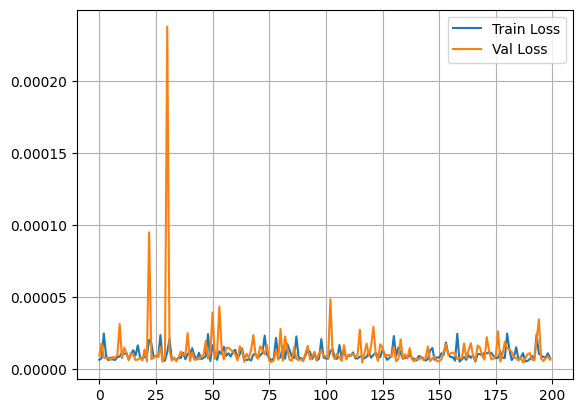

In [171]:
plt.figure()
plt.plot(losses[-200:], label = "Train Loss")
plt.plot(val_losses[-200:], label = "Val Loss")
plt.legend()
plt.grid(True)
plt.show()

In [185]:
torch.save(model.state_dict(), "./trained_model.pt")

## Make predictions

In [174]:
X_batch, y_batch, Ybus_batch, attention = next(iter(test_loader))
X_batch = X_batch.to(torch.float)
y_batch = y_batch.to(torch.float)
attention = attention.to(torch.float)

y_pred = model(X_batch, Ybus_batch, attention)

loss = criterion(y_pred, y_batch)
print(loss.item())

7.640034709766041e-06


In [177]:
torch.concatenate([y_pred, y_batch], dim=1)

tensor([[1.0380, 0.2431, 1.0397, 0.2455],
        [1.0449, 0.2787, 1.0458, 0.2792],
        [1.0276, 0.6287, 1.0299, 0.6299],
        [1.0402, 0.2294, 1.0411, 0.2306],
        [1.0431, 0.1939, 1.0446, 0.1946],
        [1.0408, 0.1053, 1.0433, 0.1101],
        [1.0399, 0.1634, 1.0422, 0.1693],
        [1.0397, 0.0990, 1.0412, 0.1044],
        [1.0375, 0.1678, 1.0387, 0.1701],
        [1.0286, 0.4951, 1.0275, 0.4992],
        [1.0348, 0.1929, 1.0364, 0.1980],
        [1.0419, 0.2348, 1.0429, 0.2367],
        [1.0126, 0.5012, 1.0142, 0.5018],
        [1.0410, 0.2374, 1.0419, 0.2387],
        [1.0425, 0.1865, 1.0440, 0.1878],
        [1.0451, 0.3117, 1.0461, 0.3119],
        [1.0388, 0.1338, 1.0398, 0.1350],
        [1.0299, 0.5011, 1.0230, 0.5014],
        [1.0459, 0.2659, 1.0464, 0.2664],
        [1.0353, 0.1756, 1.0363, 0.1775],
        [1.0420, 0.1726, 1.0435, 0.1738],
        [1.0097, 0.6992, 1.0068, 0.7099],
        [1.0370, 0.1178, 1.0376, 0.1186],
        [1.0406, 0.1509, 1.0421, 0

In [183]:
y_pred[:,0]*230

tensor([238.7490, 240.3360, 236.3521, 239.2538, 239.9209, 239.3781, 239.1750,
        239.1202, 238.6320, 236.5702, 238.0125, 239.6359, 232.8907, 239.4202,
        239.7857, 240.3827, 238.9296, 236.8802, 240.5458, 238.1085, 239.6576,
        232.2310, 238.5063, 239.3456, 234.1517, 236.5273, 237.5104, 238.6529,
        236.6960, 240.5523, 239.1394, 239.4891], grad_fn=<MulBackward0>)

In [184]:
y_batch[:,0]*230

tensor([239.1342, 240.5446, 236.8735, 239.4469, 240.2610, 239.9495, 239.6965,
        239.4674, 238.9014, 236.3140, 238.3812, 239.8699, 233.2763, 239.6365,
        240.1085, 240.5930, 239.1545, 235.2819, 240.6797, 238.3505, 239.9969,
        231.5654, 238.6539, 239.6872, 234.4624, 236.3175, 235.8653, 238.9759,
        236.2185, 240.7267, 239.2840, 239.7231])

dataset = IEEE9Dataset()

torch.tensor([y_pred, y_batch])